In [1]:
%matplotlib inline

In [2]:
#Import all our dependencies
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from skimage import io, transform
from skimage.transform import rotate

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import os

import wandb
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
#Initialize weight and biases trial so we can monitor our trials
#Make sure to rerun this cell before every trial!
wandb.init(project="kevin-behavior-cloning-training", entity="launchkart")
#TODO: Name this something descriptive, and make sure to rename the trial name for different trials!
wandb.run.name = "kevin-trial-1"
wandb.run.save()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: launchkart (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [ ]:
#Create our torch device, which will be cuda if GPU and cpu if just using CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [47]:
x = np.load("data/X.npy")
y = np.load("data/y.npy")
#If you are loading more than one npy file, you will need to load all of them and then use vstack to concatenate them all together 
# x = np.vstack(x, ...)
# y = np.vstack(y, ...)

#Split our training data into a training set and validation set
split_idx = int(0.8 * len(x))
x_train, x_val = x[:split_idx], x[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

#Look at our training set shapes
print(x_train.shape)
print(y_train.shape)


(394, 66, 200, 3)
(394, 5)


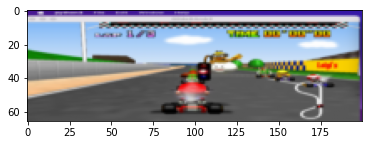

In [49]:
image = x[1]
plt.imshow(image)

There are 493 samples
/Users/chevin/Desktop/Launchpad/Launchkart/samples/luigi/img_0.png
[[[0.27843137 0.09019608 0.57254902]
  [0.27843137 0.09019608 0.57254902]
  [0.27843137 0.09019608 0.57254902]
  ...
  [0.20784314 0.09019608 0.65098039]
  [0.20784314 0.09019608 0.65098039]
  [0.20784314 0.09019608 0.65098039]]

 [[0.27843137 0.09019608 0.57254902]
  [0.27843137 0.09019608 0.57254902]
  [0.27843137 0.09019608 0.57254902]
  ...
  [0.20784314 0.09019608 0.65098039]
  [0.20784314 0.09019608 0.65098039]
  [0.20784314 0.09019608 0.65098039]]

 [[0.28472371 0.09787879 0.57153298]
  [0.28966132 0.10534759 0.57593583]
  [0.28966132 0.10534759 0.57593583]
  ...
  [0.21176471 0.09385027 0.65098039]
  [0.20784314 0.09019608 0.65098039]
  [0.20784314 0.09019608 0.65098039]]

 ...

 [[0.30980392 0.30980392 0.30980392]
  [0.30980392 0.30980392 0.30980392]
  [0.30980392 0.30980392 0.30980392]
  ...
  [0.3526738  0.35240642 0.3526738 ]
  [0.34588235 0.28901961 0.38352941]
  [0.30196078 0.08784314

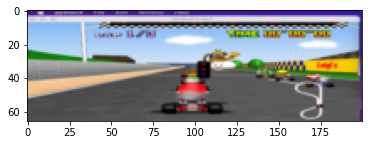

In [30]:
from skimage.io import imread
from skimage.transform import resize

def load_sample(sample):
    image_files = np.loadtxt(sample + '/data.csv', delimiter=',', dtype=str, usecols=(0,))
    joystick_values = np.loadtxt(sample + '/data.csv', delimiter=',', usecols=(1,2,3,4,5))
    return image_files, joystick_values

def resize_image(img):
    im = resize(img, (66, 200, 3))
    im_arr = im.reshape((66, 200, 3))
    return im_arr

def prepare(sample):
    image_files, joystick_values = load_sample(sample)
    num_samples = len(image_files)

    print(f"There are {num_samples} samples")

    X = np.empty(shape=(num_samples, 66, 200, 3), dtype=np.float64)
    y = []

    y.append(joystick_values)

    # load, prepare and add images to X
    idx = 0
    for image_file in image_files:
        print(image_file)
        image = imread(image_file)
        plt.imshow(image)
        vec = resize_image(image)
        print(vec)
        plt.imshow(vec)
        X[idx] = vec
        idx += 1
        if idx > 0:
            break

    y = np.concatenate(y)
prepare("samples/luigi")

In [ ]:
#Torch has a Datasets class that makes it easy to interface with datasets when training
#This is mostly filled in for you, although we will add data augmentation later
class MarioKartDataset(Dataset):
    """Nose Keypoints dataset."""
    
    #Create a list of samples, where each sample is a tensor with an observation (image) and an action (vector of controller input)
    def __init__(self, x, y):
        self.samples = []
        for i in range(len(x)):
            x_sample, y_sample = x[i], y[i]
            sample = {'obs': x_sample, 'action': y_sample}

            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)
    
    #Gets the item at index idx from our samples
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.samples[idx]
        
        #Ignore this todo until we've covered it in project meeting: 
        #TODO: Apply data augmentation here
        
        return sample


In [ ]:
#Create a training and validation dataset
mario_kart_train_dataset = MarioKartDataset(x_train, y_train)
mario_kart_val_dataset = MarioKartDataset(x_val, y_val)
print(len(mario_kart_train_dataset))

In [ ]:
#Torch uses DataLoaders to handle shuffling datasets and loading batches of data
#You can experiment with different batch sizes here
#Num_workers can be set to 1 if using GPU
batch_size=64
mario_kart_train_dataloader = DataLoader(mario_kart_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
mario_kart_val_dataloader = DataLoader(mario_kart_val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
#TODO: Define your agent architecture here
#Take a look at our MNIST tutorial for reference.
#Recommended architecture is covered in meeting slides
#Note: The in dimension for the first fully connected layer is very hard to calculate, can prob just run first and determine based on the error message
#Note: Use Sequential to keep your code organized
class MarioKartBCAgent(nn.Module):
    def __init__(self):
        super(MarioKartBCAgent, self).__init__()
        
        #Feature Extraction Module: Conv layers (check out Conv2d, BatchNorm, Relu, Maxpool)
        ...
        #Inference Module: Fully connected layers (check out Linear, Dropout, Relu)
        
    def forward(self, x):
        #Pass x through conv layers
        x = ...
        
        #Flatten x to prepare for passing into linear
        x = torch.flatten(x, 1) 
        
        #Pass x through linear layers
        x = ...
        
        #Name variable output on last layer
        output = ...
        
        return output    # return x for visualization


In [ ]:
#This is the cell where we define our training loop
#It is mostly implemented already, but make sure to read through all of it to understand what is happening

agent = MarioKartBCAgent()

#Change the trial_name to something descriptive, based on what data you are using for training
trial_name = 'kevin_luigicircuit_timetrials/'
save_path = 'saved_agents/'


cwd = os.getcwd()
agent_dir = os.path.join(cwd,save_path)
trial_dir = os.path.join(agent_dir, trial_name)
if not os.path.exists(agent_dir):
    os.mkdir(agent_dir)
if not os.path.exists(trial_dir):
    os.mkdir(trial_dir)
    
#Change the checkpoint number if you are loading a model from a checkpoint for further training
checkpoint = 0
# agent.load_state_dict(torch.load(save_path + trial_name + str(checkpoint)))

#Define your learning rate and number of epochs to train for
lr = 1e-3
epochs = 100

#Initialize your optimizer and loss
optimizer = ...
criterion = ...

#This config is for WandB to track the hyperparameters we used for this run
wandb.config = {
  "learning_rate": lr,
  "checkpoint": checkpoint,
  "trial_name": trial_name,
  "epochs": epochs,
  "batch_size": batch_size
}

training_losses = []
validation_losses = []

#Iterate through number of epochs
for epoch in range(epochs):
    epoch_training_losses = []
    epoch_validation_losses = []
    
    #Iterate through our dataloader batch by batch
    for _, sample_batched in enumerate(mario_kart_train_dataloader):
        
        #Creates an observation and action batch
        obs_batch, action_batch = np.transpose(sample_batched['obs'], (0, 3, 1, 2)), sample_batched['action']
        obs_batch, action_batch = obs_batch.float().to(device), action_batch.float().to(device)
        
        #Optimizer performs a parameter update step based on loss calculated between predicted and grond truth actions
        optimizer.zero_grad() 
        pred_action = agent(obs_batch)
        loss = criterion(pred_action, action_batch.reshape(pred_action.shape))
        loss.backward()
        optimizer.step()
        
        epoch_training_losses.append(loss.item())
    
    #Keep track of training losses every epoch and log with WandB
    training_loss = np.mean(epoch_training_losses)
    print("Finished Epoch", epoch + 1, ", training loss:", training_loss)
    training_losses.append(training_loss)
    wandb.log({"training_loss": training_loss})

    #After every epoch, test agent performance on validation set, which it has not trained on
    #This is to make sure we aren't overfitting too hard, and are generalizing well
    with torch.no_grad():
        #Set agent to evaluation mode so we aren't calculating gradients
        agent.eval()
        
        #Iterate through our validation dataloder batch by batch
        for _, sample_batched in enumerate(mario_kart_val_dataloader):
            obs_batch, action_batch = np.transpose(sample_batched['obs'], (0, 3, 1, 2)), sample_batched['action']
            obs_batch, action_batch = obs_batch.float().to(device), action_batch.float().to(device)
            pred_action = agent(obs_batch)
            val_loss = criterion(pred_action, action_batch.reshape(pred_action.shape))
            epoch_validation_losses.append(val_loss.item())
        
        #Keep track of validationlosses every epoch and log with WandB
        validation_loss = np.mean(epoch_validation_losses)
        print("Epoch ", epoch +1, ", validation_loss: ", validation_loss)
        validation_losses.append(validation_loss)
        wandb.log({"validation_loss": validation_loss})
        agent.train()
    
    #Save agent checkpoint every 10 epochs
    if epoch == 0 || epoch % 10 == 9:
        torch.save(agent.state_dict(), save_path + trial_name + str(epoch))
